In [ ]:
!pip install snowflake
!pip install sklearn

!pip install snowflake-snowpark-python

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


### imoprt packages

In [ ]:
from snowflake.snowpark.session import Session
import sys
from snowflake.snowpark.functions import col, lit, sum ,max


from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns
import pandas as pd
import random

random.seed(1)

In [ ]:

snowflake_connection_parameters = {
   "user":"BIGDATA",
    "account":"BNYTXUB-TH07367",
    "password":"Ffbuxv5.RsM.ZQm",
    "database":"BIG_DATA_PROJECT",
    "schema":"PUBLIC"
}
TABLE_NAME="TAXI_TRIPS_CLEANED"

In [ ]:
snowpark_session = Session.builder.configs(snowflake_connection_parameters).create()


In [ ]:
snowpark_session.sql("USE DATABASE BIG_DATA_PROJECT").show()

------------------------------------
|"status"                          |
------------------------------------
|Statement executed successfully.  |
------------------------------------



In [ ]:
taxi_df = snowpark_session.table(TABLE_NAME)

In [ ]:
taxi_df.columns

['VENDORID',
 'PASSENGER_COUNT',
 'TRIP_DISTANCE',
 'PULOCATIONID',
 'DOLOCATIONID',
 'PAYMENT_TYPE',
 'FARE_AMOUNT',
 'EXTRA',
 'MTA_TAX',
 'TIP_AMOUNT',
 'TOLLS_AMOUNT',
 'IMPROVEMENT_SURCHARGE',
 'TOTAL_AMOUNT',
 'CONGESTION_SURCHARGE',
 'PICKUP_TIMESTAMP',
 'DROPOFF_TIMESTAMP']

In [ ]:
pd_taxi_df=taxi_df.select('TRIP_DISTANCE',"TIP_AMOUNT",'FARE_AMOUNT',"TOTAL_AMOUNT").to_pandas()
pd_taxi_df.head(5)

,TRIP_DISTANCE,TIP_AMOUNT,FARE_AMOUNT,TOTAL_AMOUNT
0,0.99,1.86,6.0,11.16
1,1.62,0.00,7.0,10.30
2,1.91,2.56,9.5,15.36
3,3.95,0.00,16.0,19.30
4,6.23,1.00,23.0,27.30


In [ ]:
pd_taxi_df.shape

(10106061, 4)

In [ ]:
pd_taxi_df.head(5)

,TRIP_DISTANCE,TIP_AMOUNT,FARE_AMOUNT,TOTAL_AMOUNT
0,0.99,1.86,6.0,11.16
1,1.62,0.00,7.0,10.30
2,1.91,2.56,9.5,15.36
3,3.95,0.00,16.0,19.30
4,6.23,1.00,23.0,27.30


### Print the Correlation heatmap

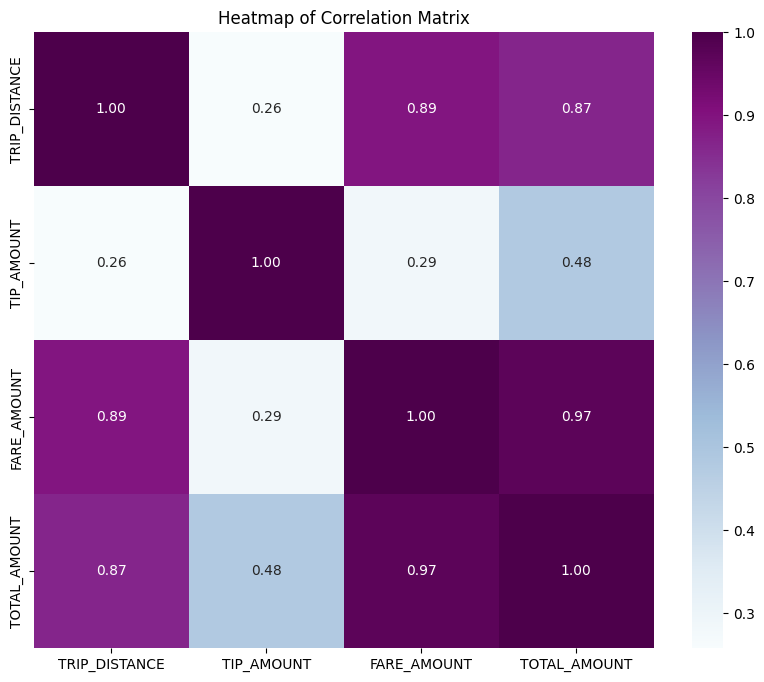

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = pd_taxi_df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='BuPu', fmt=".2f")
plt.title('Heatmap of Correlation Matrix')
plt.show()


### Splitting the data


In [ ]:

X=pd_taxi_df.drop(columns=['TOTAL_AMOUNT'])
Y=pd_taxi_df['TOTAL_AMOUNT']
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=75 ,train_size=0.8,shuffle=True)# spilt the data for two parts 80% for train and 20% for test

## Training the two models

In [ ]:


X=pd_taxi_df.drop(columns=['TOTAL_AMOUNT'])
Y=pd_taxi_df['TOTAL_AMOUNT']
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=75 ,train_size=0.8,shuffle=True)# spilt the data for two parts 80% for train and 20% for test
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
predciction_list=[]

models = [('Linear Regression', lr_model), ('Decision Tree', dt_model)]
for name, model in models:
    y_pred = model.predict(X_test)
    predciction_list.append(y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name}:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')
    print()


Linear Regression:
Mean Squared Error: 0.4777782149554017
R-squared: 0.9913865396856206

Decision Tree:
Mean Squared Error: 0.45110663930451683
R-squared: 0.9918673790190178



  ## Comparing the preformance of the two models

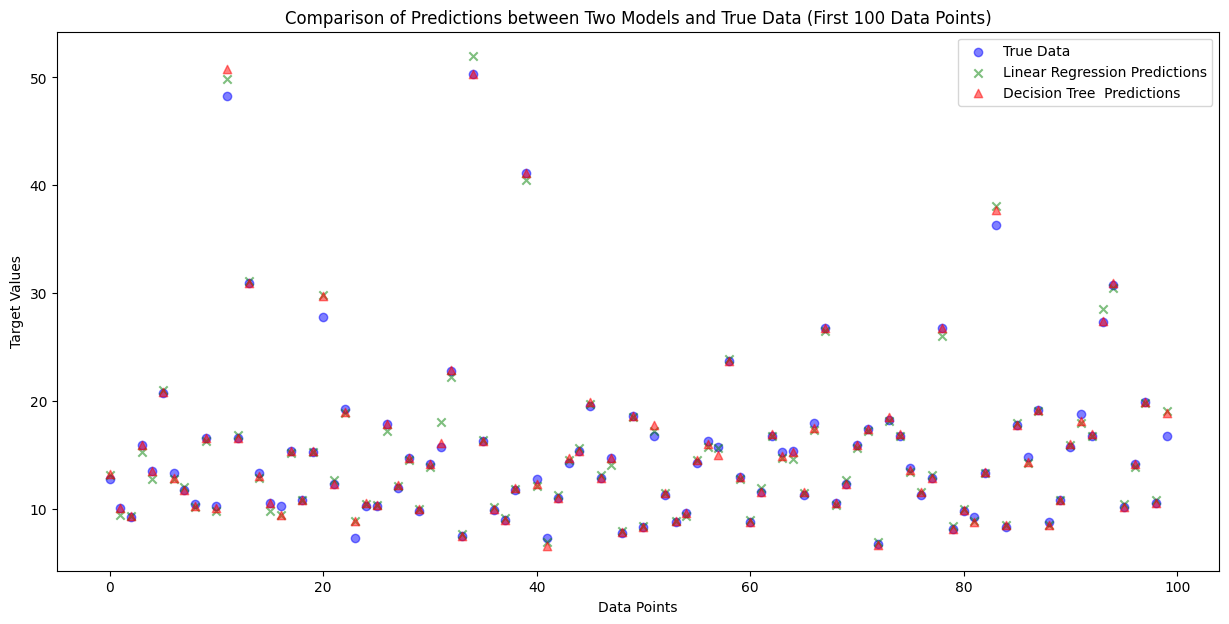

In [ ]:
# Select the first 1000 data points for better visualization
num_samples = 100

plt.figure(figsize=(15, 7))

# Plotting true values for the selected subset
plt.scatter(range(num_samples), y_test[:num_samples], label='True Data', color='blue', marker='o', alpha=0.5)

# Plotting predictions from Model 1 (Linear Regression)
plt.scatter(range(num_samples), predciction_list[0][:num_samples], label='Linear Regression Predictions', color='green', marker='x', alpha=0.5)

# Plotting predictions from Model 2 (Decision Tree)
plt.scatter(range(num_samples), predciction_list[1][:num_samples], label='Decision Tree  Predictions', color='red', marker='^', alpha=0.5)

# Adding labels and legend
plt.xlabel('Data Points')
plt.ylabel('Target Values')
plt.legend()
plt.title('Comparison of Predictions between Two Models and True Data (First 100 Data Points)')

plt.show()

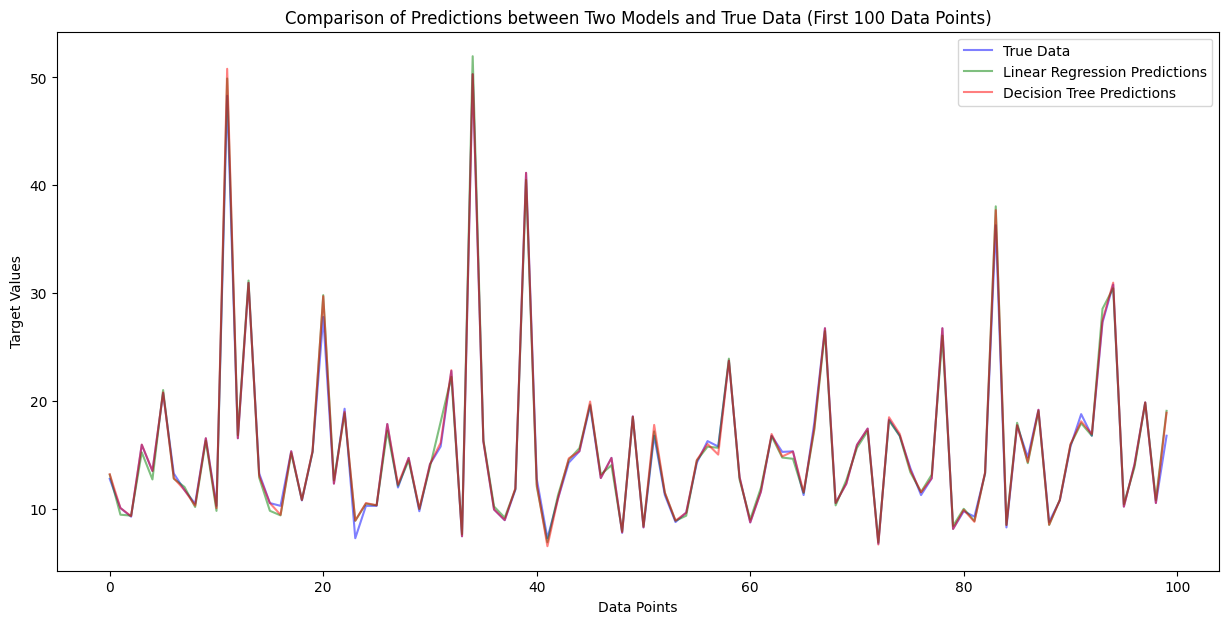

In [ ]:
# Select the first 100 data points for better visualization
num_samples = 100

plt.figure(figsize=(15, 7))

# Plotting true values as lines for the selected subset
plt.plot(range(num_samples), y_test[:num_samples], label='True Data', color='blue', linestyle='-', alpha=0.5)

# Plotting predictions from Model 1 (Linear Regression) as lines
plt.plot(range(num_samples),  predciction_list[0][:num_samples], label='Linear Regression Predictions', color='green', linestyle='-', alpha=0.5)

# Plotting predictions from Model 2 (Decision Tree) as lines
plt.plot(range(num_samples), predciction_list[1][:num_samples], label='Decision Tree Predictions', color='red', linestyle='-', alpha=0.5)

# Adding labels and legend
plt.xlabel('Data Points')
plt.ylabel('Target Values')
plt.legend()
plt.title('Comparison of Predictions between Two Models and True Data (First 100 Data Points)')

plt.show()